In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional, TimeDistributed, InputLayer
from tensorflow.keras.layers import Embedding, Conv1D, Input, concatenate, SpatialDropout1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

![](https://i.stack.imgur.com/WSOie.png)

![](https://user-images.githubusercontent.com/31881382/35037901-f4a69b14-fb89-11e7-8c28-08a0cb1310cb.png)

In [2]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

Сегодня узнаем, как в Keras построить сеть для задачи  **pos- тэггинга** (many-to-many). Решать задачу будем на **WSJ корпус**е, взятом из nltk.
Задача состоит в том, чтобы каждому слову в предложении сопоставить один тэг из [определенного набора](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html). 

Как на схеме выше, мы хотим использовать и словные эмбеддинги и вектора признаков, полученные с помощью сверток на символах. Для этого нам понадобится сделать два входа в нашу сеть, один будет брать вектора индексов слов(которые потом будут подаваться  Embedding  слою), а другой будет рассматривать каждое слово, как вектор индексов его букв.

In [3]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()

In [4]:
len(tagged_sentences)

3914

In [5]:
tagged_sentences[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [6]:
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(sentence)
    sentence_tags.append(tags)

In [7]:
sentences[0]

('Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.')

In [8]:
sentence_tags[0]

('NNP',
 'NNP',
 ',',
 'CD',
 'NNS',
 'JJ',
 ',',
 'MD',
 'VB',
 'DT',
 'NN',
 'IN',
 'DT',
 'JJ',
 'NN',
 'NNP',
 'CD',
 '.')

In [9]:
sent_train, sent_test, tag_train, tag_test = train_test_split(sentences, sentence_tags, test_size=0.2, random_state=1)

Итак, нам нужны три словаря:  **word2id**, **char2id**  -  для двух входов в сеть и **tag2id** - для кодирования выхода

In [10]:
vocab = Counter()
for sent in sent_train:
    sent = [word.lower() for word in sent]
    vocab.update(sent)

In [11]:
filtered_vocab = {word for word in vocab if vocab[word] > 5}

In [12]:
len(filtered_vocab)

1705

In [13]:
word2id = {word:i + 2 for i,word in enumerate(filtered_vocab)}
word2id['pad'] = 0
word2id['unk'] = 1  

id2word = {i:word for word, i in word2id.items()}

In [14]:
len(id2word)

1707

In [15]:
tag2id = {'pad':0, 'unk':1}  
for tags in tag_train:
    for tag in tags:
      if tag.lower() not in tag2id:
        tag2id[tag.lower()] = len(tag2id)

id2tag = {i:tag for tag, i in tag2id.items()}

In [16]:
id2tag

{0: 'pad',
 1: 'unk',
 2: 'nnp',
 3: 'vbd',
 4: 'nn',
 5: '-none-',
 6: 'to',
 7: 'vb',
 8: 'jjr',
 9: 'in',
 10: 'cd',
 11: 'pos',
 12: ',',
 13: 'vbg',
 14: 'prp',
 15: 'md',
 16: '.',
 17: 'dt',
 18: 'vbn',
 19: 'cc',
 20: ':',
 21: '$',
 22: 'rb',
 23: 'nns',
 24: 'vbp',
 25: 'jj',
 26: '``',
 27: 'vbz',
 28: "''",
 29: 'jjs',
 30: 'wdt',
 31: 'rbr',
 32: 'nnps',
 33: 'wp',
 34: 'prp$',
 35: 'rp',
 36: '-lrb-',
 37: '-rrb-',
 38: 'pdt',
 39: 'wrb',
 40: 'ex',
 41: 'ls',
 42: 'rbs',
 43: 'wp$',
 44: '#',
 45: 'fw',
 46: 'uh'}

In [17]:
chars = set([letter for word in filtered_vocab for letter in word])
n_chars = len(chars)
print(chars)


{'v', 'e', 'o', 'i', 'k', '7', 's', '!', 'x', "'", '`', 'b', '4', '\\', '#', '*', '/', 'z', '2', 'h', 'n', 'p', '1', 'q', '&', 'l', 'w', '5', ':', 'm', 'y', '0', 'c', 'j', 'g', ';', 'd', '3', '%', 'u', 'a', '.', ',', '9', '8', 't', 'f', '-', '6', '?', '$', 'r'}


In [18]:
char2id = {c: i + 2 for i, c in enumerate(chars)}
char2id["pad"] = 0
char2id["unk"] = 1

id2char = {i:char for char, i in char2id.items()}

In [19]:
char_max_len = max(len(x) for x in filtered_vocab)
print("максимальная длина слова:", char_max_len)

максимальная длина слова: 16


In [20]:
def data2ints(data, smth2id):
  int_data = []
  for seq in data:
      int_seq = []
      for i in seq:
        int_seq.append(smth2id.get(i.lower(), 1))
  
      int_data.append(int_seq)
  return int_data
 

In [21]:
X_train_ids, X_test_ids = data2ints(sent_train, word2id), data2ints(sent_test, word2id)
y_train_ids, y_test_ids = data2ints(tag_train, tag2id), data2ints(tag_test, tag2id)


print(X_train_ids[0])
print(y_train_ids[0])

print(X_test_ids[0])
print(y_test_ids[0])

[762, 30, 1, 226, 1493, 1029, 1065, 70, 1391, 289, 1370, 244, 1147, 1183, 658, 949, 438, 976, 271, 1119, 226, 870, 1180, 1460, 151, 463]
[2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 4, 9, 2, 2, 11, 4, 5, 12, 5, 13, 5, 14, 15, 7, 4, 16]
[11, 769, 1362, 912, 825, 1577, 1029, 769, 1, 517, 976, 464, 825, 1331, 195, 769, 1636, 244, 517, 976, 1384, 472, 769, 97, 976, 992, 186, 122, 795, 588, 633, 1, 1576, 782, 1, 1, 1, 463]
[9, 17, 25, 4, 15, 7, 6, 17, 29, 23, 12, 14, 15, 22, 7, 17, 4, 9, 23, 12, 25, 9, 17, 4, 12, 30, 5, 22, 24, 18, 25, 4, 4, 19, 24, 25, 23, 16]


In [22]:
sent_max_len = max(len(x) for x in X_train_ids)
print("максимальная длина предложения:", sent_max_len)

максимальная длина предложения: 271


In [23]:
X_train, X_test = pad_sequences(X_train_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_test_ids, maxlen=sent_max_len, padding='post')
y_train, y_test = pad_sequences(y_train_ids, maxlen=sent_max_len, padding='post'), pad_sequences(y_test_ids, maxlen=sent_max_len, padding='post')

In [24]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3131, 271) (3131, 271) (783, 271) (783, 271)


In [25]:
def make_X_char(sentences):
  X_char = []
  for sentence in sentences:
      sent_seq = []
      for i in range(sent_max_len):
          word_seq = []
          for j in range(char_max_len):
              try:
                  word_seq.append(char2id[sentence[i][j].lower()])
              except:
                  word_seq.append(char2id["pad"])
          sent_seq.append(word_seq)
      X_char.append(np.array(sent_seq))
  return np.array(X_char)

    

In [26]:
X_char_train, X_char_test = make_X_char(sent_train), make_X_char(sent_test)

In [27]:
X_char_train.shape

(3131, 271, 16)

Посмотрим на одном примере, правильно ли мы перевели текст в индексы.

In [28]:
sent_train[5][0]

'Safety'

In [29]:
X_char_train[5][0]

array([ 8, 42, 48,  3, 47, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [30]:
[id2char[i] for i in X_char_train[5][0]]

['s',
 'a',
 'f',
 'e',
 't',
 'y',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad']

In [31]:
X_train[5]

array([1402,    1,  976, 1684,  970,  640,  244,  928,  976,  795,  608,
          1,  769, 1127, 1626,  208,   59, 1029,  192,    1,  357, 1029,
        429,  566,   91,    1,  976,  828,   71,    1,  985, 1626, 1519,
          1,  244,  324,    1, 1346,  472,  769, 1610,  463,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [32]:
[id2word[i] for i in X_train[5]][:50]

['safety',
 'unk',
 ',',
 'including',
 'some',
 'members',
 'of',
 'congress',
 ',',
 'have',
 'been',
 'unk',
 'the',
 'department',
 'for',
 'years',
 '*-2',
 'to',
 'extend',
 'unk',
 'requirements',
 'to',
 'light',
 'trucks',
 'and',
 'unk',
 ',',
 'which',
 'now',
 'unk',
 'account',
 'for',
 'almost',
 'unk',
 'of',
 'all',
 'unk',
 'sales',
 'in',
 'the',
 'u.s.',
 '.',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad']

Посмотрите, как быстро сделать one-hot вектора. В данном случае нам нужно преобразовать в такой вид матрицы ответов y_train, y_test, если мы хотим  использовать loss="categorical_crossentropy"

In [33]:
# пример работы ф-ции 
to_categorical(y=[3,0,2], num_classes=5)

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [34]:
y_train, y_test = to_categorical(y_train, num_classes=len(tag2id)), to_categorical(y_test, num_classes=len(tag2id))

In [35]:
y_train.shape

(3131, 271, 47)

Мы готовы писать саму сеть. Сначала посмотрим на простейшую  LSTM.

In [36]:
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=20, mask_zero=True)(word_in)
lstm = Bidirectional(LSTM(units=128, return_sequences=True,recurrent_dropout=0.2))(emb_word)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(lstm)

model = Model(inputs= word_in, outputs=out)

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])


In [37]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 271)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 271, 20)           34140     
_________________________________________________________________
bidirectional (Bidirectional (None, 271, 256)          152576    
_________________________________________________________________
time_distributed (TimeDistri (None, 271, 47)           12079     
Total params: 198,795
Trainable params: 198,795
Non-trainable params: 0
_________________________________________________________________


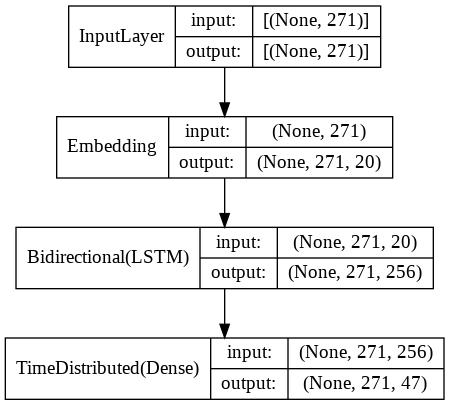

In [38]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False)

In [39]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=30, verbose=1)

Epoch 1/30
25/25 [==============================] - 65s 2s/step - loss: 0.3506 - acc: 0.1190 - val_loss: 0.2902 - val_acc: 0.1191
Epoch 2/30
25/25 [==============================] - 60s 2s/step - loss: 0.2878 - acc: 0.1377 - val_loss: 0.2817 - val_acc: 0.1497
Epoch 3/30
25/25 [==============================] - 61s 2s/step - loss: 0.2833 - acc: 0.1555 - val_loss: 0.2763 - val_acc: 0.1536
Epoch 4/30
25/25 [==============================] - 61s 2s/step - loss: 0.2789 - acc: 0.1630 - val_loss: 0.2678 - val_acc: 0.2463
Epoch 5/30
25/25 [==============================] - 60s 2s/step - loss: 0.2637 - acc: 0.2565 - val_loss: 0.2489 - val_acc: 0.3621
Epoch 6/30
25/25 [==============================] - 61s 2s/step - loss: 0.2423 - acc: 0.4042 - val_loss: 0.2044 - val_acc: 0.4592
Epoch 7/30
25/25 [==============================] - 60s 2s/step - loss: 0.1926 - acc: 0.4758 - val_loss: 0.1573 - val_acc: 0.5478
Epoch 8/30
25/25 [==============================] - 60s 2s/step - loss: 0.1481 - acc: 0.57

In [40]:
# один вход для слов
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=20, mask_zero=True)(word_in)

# другой вход для символов
char_in = Input(shape=(sent_max_len, char_max_len))
emb_char = TimeDistributed(Embedding(input_dim=len(char2id), output_dim=10, input_length=char_max_len))(char_in)
# свертка на символах (CharRNN) применяется к каждому слову отдельно
char_enc = TimeDistributed(Conv1D(filters=12, kernel_size=3))(emb_char)
char_flat = TimeDistributed(Flatten())(char_enc)

# LSTM проходится по всей последовательности, на каждом шаге беря эмбеддинг слова по словарю + символьный эмбеддинг слова 
x = concatenate([emb_word, char_flat])
main_lstm = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2))(x)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(main_lstm)

model = Model(inputs=[char_in, word_in], outputs=out)


optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])


In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 271, 16)]    0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 271, 16, 10)  540         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 271)]        0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 271, 14, 12)  372         time_distributed_1[0][0]         
____________________________________________________________________________________________

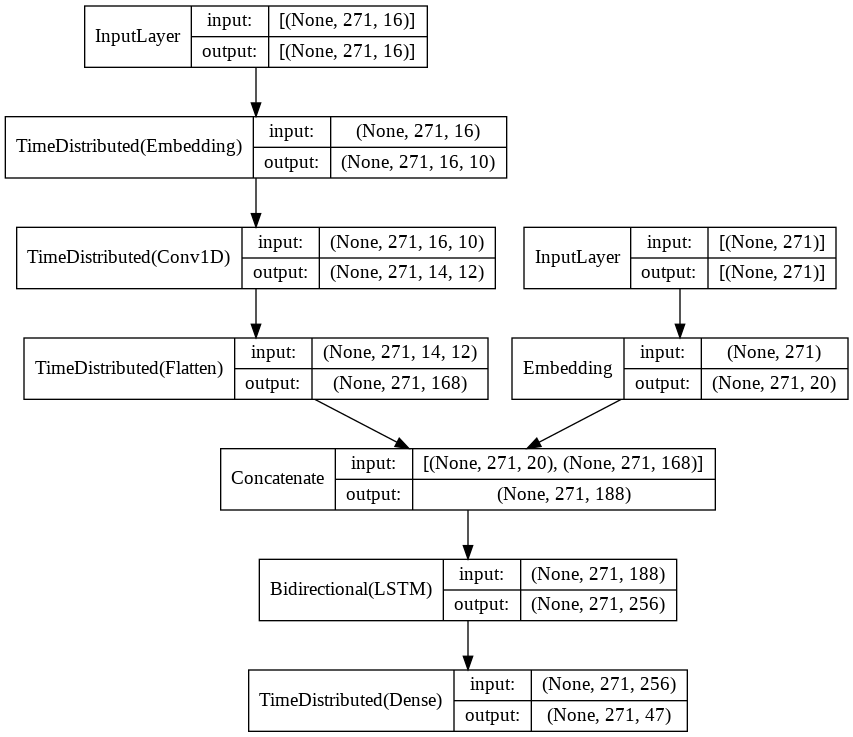

In [42]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [43]:
model.fit([X_char_train, X_train], y_train, validation_data=([X_char_test, X_test], y_test), batch_size=128, epochs=30, verbose=1)

Epoch 1/30
25/25 [==============================] - 100s 4s/step - loss: 0.3369 - acc: 0.1059 - val_loss: 0.2822 - val_acc: 0.1637
Epoch 2/30
25/25 [==============================] - 94s 4s/step - loss: 0.2839 - acc: 0.1637 - val_loss: 0.2700 - val_acc: 0.1827
Epoch 3/30
25/25 [==============================] - 94s 4s/step - loss: 0.2672 - acc: 0.2265 - val_loss: 0.2401 - val_acc: 0.3755
Epoch 4/30
25/25 [==============================] - 94s 4s/step - loss: 0.2276 - acc: 0.3905 - val_loss: 0.1843 - val_acc: 0.4604
Epoch 5/30
25/25 [==============================] - 93s 4s/step - loss: 0.1771 - acc: 0.4871 - val_loss: 0.1406 - val_acc: 0.5780
Epoch 6/30
25/25 [==============================] - 94s 4s/step - loss: 0.1319 - acc: 0.6048 - val_loss: 0.1093 - val_acc: 0.6760
Epoch 7/30
25/25 [==============================] - 95s 4s/step - loss: 0.1035 - acc: 0.7050 - val_loss: 0.0859 - val_acc: 0.7692
Epoch 8/30
25/25 [==============================] - 95s 4s/step - loss: 0.0807 - acc: 0.7

#### **Иллюстрация того, как работает Embedding слой, и как выглядит маска, которая в нем создается**

In [44]:
# Вот наши 2 текста:
sent1 = "а кто это".split()
sent2 = "кто кто".split()
word2id_small = {"pad":0, "а":1, "кто":2,"это":3}


In [45]:
# сделаем игрушечный батч из двух примеров (допустим максимальная длина предложений у нас в обучающих данных - 5). 
ex_batch = data2ints([sent1,sent2], word2id_small)
ex_batch = pad_sequences(ex_batch, maxlen=5,padding='post')
print(ex_batch)

[[1 2 3 0 0]
 [2 2 0 0 0]]


In [46]:
#создадим Embedding слой. Он отвечает за то, чтобы любому входному слову сопоставлять вектор заданной длины. Его веса - матрица размера "величина словаря"*"длина эмбеддинга".
#i-ая строка в этой матрице - эмбеддинг  слова с индексом i.Посмотрим на это глазами 
#Чтобы создать слой через Keras, мы должны задать параметры матрицы весов слоя input_dim = величина словаря  output_dim = длина желаемого эмбеддинга 
emb_word = Embedding(input_dim=len(word2id_small), output_dim=3, mask_zero=True)
#теперь применим слой к нашему батчу
embs = emb_word(ex_batch)

In [47]:
# посмотрим на результат.
#Мы получили 2 матрицы 5*3 (так как в батче два предложения, каждое длины 5, и для каждого слова мы слой отдал эмбеддинг по индексу слова). 
embs

<tf.Tensor: shape=(2, 5, 3), dtype=float32, numpy=
array([[[ 0.03985948, -0.01759938, -0.01331428],
        [ 0.04204455,  0.03518117,  0.02365774],
        [ 0.02546543, -0.01613904, -0.04238384],
        [ 0.0153942 ,  0.04046488, -0.0051047 ],
        [ 0.0153942 ,  0.04046488, -0.0051047 ]],

       [[ 0.04204455,  0.03518117,  0.02365774],
        [ 0.04204455,  0.03518117,  0.02365774],
        [ 0.0153942 ,  0.04046488, -0.0051047 ],
        [ 0.0153942 ,  0.04046488, -0.0051047 ],
        [ 0.0153942 ,  0.04046488, -0.0051047 ]]], dtype=float32)>

In [48]:
# убедитесь в том, что эмбеддинг i-того слова  - i-тая строка из матрицы весов, посмотрев на всю матрицу весов
emb_word.get_weights()

[array([[ 0.0153942 ,  0.04046488, -0.0051047 ],
        [ 0.03985948, -0.01759938, -0.01331428],
        [ 0.04204455,  0.03518117,  0.02365774],
        [ 0.02546543, -0.01613904, -0.04238384]], dtype=float32)]

In [49]:
# так как мы создавали слой с параметром mask_zero=True, то слой генерирует максу для каждого входа и передает ее дальше по слоям.
# Посмотрите, как она устроена  и как соотносится со входным батчем
embs._keras_mask

<tf.Tensor: shape=(2, 5), dtype=bool, numpy=
array([[ True,  True,  True, False, False],
       [ True,  True, False, False, False]])>